In [6]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
#library("readxl")
library("ggplot2")
library("xlsx")
library(cowplot)
library(grid)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [2]:
cntl.data <-Read10X(data.dir = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/raw_gene_bc_matrices/mm10")
colnames(cntl.data) = paste0(colnames(cntl.data),"cntl")
cntl<- CreateSeuratObject(counts = cntl.data, min.cells = 3, min.features = 200, project = "10X_LHb")
Neuron_id<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/Neuron_cntl_id.rds")
cntl<-subset(x = cntl, cells=Neuron_id)
cntl@meta.data$stim <- "cntl"

In [3]:
stim.data <-Read10X(data.dir = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/raw_gene_bc_matrices/mm10")
colnames(stim.data) = paste0(colnames(stim.data),"stim")
stim<- CreateSeuratObject(counts = stim.data, min.cells = 3, min.features = 200, project = "10X_LHb")
Neuron_id<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/all_cells/gene2000_30/Neuron_stim_id.rds")
stim<-subset(x =stim, cells=Neuron_id)
stim@meta.data$stim <- "stim"

In [4]:
mito.features <- grep(pattern = "^mt-", x = rownames(x = cntl), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = cntl, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = cntl, slot = 'counts'))
cntl[['percent.mito']] <- percent.mito

In [5]:
mito.features <- grep(pattern = "^mt-", x = rownames(x = stim), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = stim, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = stim, slot = 'counts'))
stim[['percent.mito']] <- percent.mito

In [6]:
cntl <- subset(x = cntl, subset = nCount_RNA > 700 & nCount_RNA < 15000 & percent.mito < 0.20)
stim <- subset(x = stim, subset = nCount_RNA > 700 & nCount_RNA < 15000 & percent.mito < 0.20)

In [8]:
cntl<- NormalizeData(object = cntl,verbose = FALSE) 
stim<- NormalizeData(object =stim,verbose = FALSE) 

In [9]:
cntl<- FindVariableFeatures(object =cntl,selection.method = "vst", nfeatures = 2000, verbose = FALSE)
length(x = VariableFeatures(object = cntl))
stim<- FindVariableFeatures(object =stim,selection.method = "vst", nfeatures = 2000, verbose = FALSE)
length(x = VariableFeatures(object =stim))

[1] 2000

[1] 2000

In [11]:
LHb.list<-objects()

In [12]:
LHb.list$cntl<-cntl

Warning message in LHb.list$cntl <- cntl:
“Coercing LHS to a list”

In [13]:
LHb.list$stim<-stim

In [14]:
reference.list <- LHb.list[c("cntl","stim")]
LHb.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:30)# I think this dim is CCA

Computing 2000 integration features
Scaling features for provided objects
Finding all pairwise anchors
Running CCA
Merging objects
Finding neighborhoods
Finding mutual nearest neighborhoods
	Found 7409 anchors
Filtering Anchors
	Retained 5425 anchors
Extracting within-dataset neighbors!


In [15]:
LHb.integrated <- IntegrateData(anchorset = LHb.anchors, dims = 1:30) # this is using PCA to determine weights (correction vector)

Merging dataset 1 into 2
Extracting anchors for merged samples
Finding integration vectors
Finding integration vector weights
Integrating data



Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



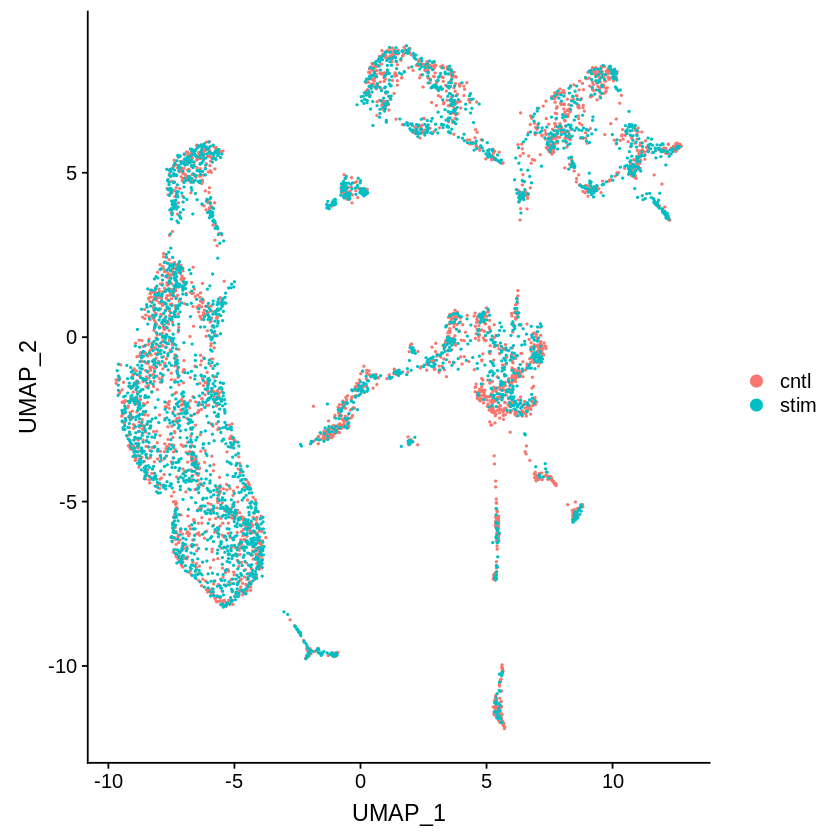

In [16]:

# switch to integrated assay. The variable features of this assay are
# automatically set during IntegrateData
DefaultAssay(object = LHb.integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
LHb.integrated <- ScaleData(object = LHb.integrated, verbose = FALSE)
LHb.integrated <- RunPCA(object = LHb.integrated, npcs = 30, verbose = FALSE)
LHb.integrated <- RunUMAP(object = LHb.integrated, reduction = "pca", 
    dims = 1:30)
p1 <- DimPlot(object = LHb.integrated, reduction = "umap", group.by = "stim")
plot_grid(p1,label_size = 30)
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/Neurons_umap.pdf",width=10,height=10)

# integrated analysis

In [17]:
LHb.integrated <- FindNeighbors(object = LHb.integrated)

Computing nearest neighbor graph
Computing SNN


In [26]:
LHb.integrated <- FindClusters(LHb.integrated, resolution = 0.8, dims.use = 1:30)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5994
Number of edges: 314157

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8885
Number of communities: 16
Elapsed time: 0 seconds


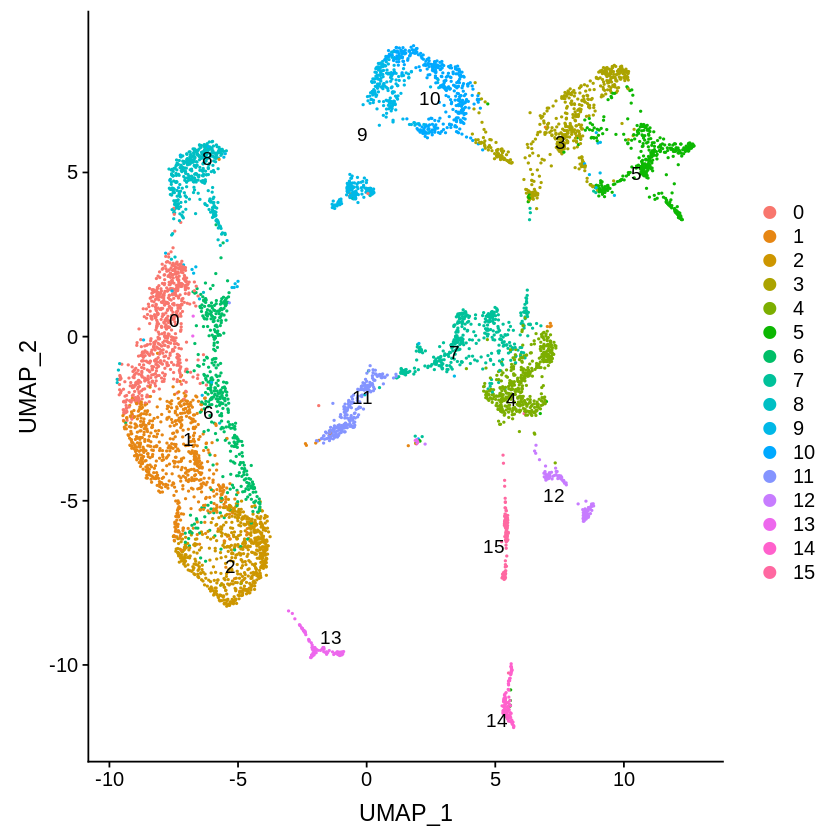

In [27]:
DimPlot(object = LHb.integrated, reduction = "umap", group.by = "integrated_snn_res.0.8", label = TRUE, repel = TRUE) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/Neurons_umap_number_2000_30_0.8.pdf",width=10,height=10)

In [8]:
F<-FeaturePlot(object =LHb.integrated, features = c("Tac2"),max.cutoff = 3,min.cutoff = 0,pt.size=1)
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/feature_habenular_tac2_2000_30.pdf",width=10,height=10)

In [23]:
F<-FeaturePlot(object =LHb.integrated, features = c("Slc17a7","Tac1","Chat","Gad2"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/feature_habenular_basic_2000_30.pdf",width=10,height=10)

In [5]:
F<-FeaturePlot(object =LHb.integrated, features = c("Tac2","Chat","Gad2","Neurod2","Chrm2"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/feature_habenular_basic2_2000_30.pdf",width=10,height=10)

In [29]:
F<-FeaturePlot(object =LHb.integrated, features = c("Pcdh10" ,"Gabra1" ,"Htr2c" ,"Cit" ,"Zfhx3"))
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/feature_habenular_basi3_2000_30.pdf",width=10,height=10)

In [21]:
saveRDS(LHb.integrated, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb_integrated_0.8.rds")

In [22]:
saveRDS(cntl, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/cntl_0.8.rds")
saveRDS(stim, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/stim_0.8.rds")

after clustering and save seurat object, you can start from here for down stream analysis

In [1]:
LHb.integrated<-readRDS(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb_integrated_0.8.rds")

In [2]:
cntl<-readRDS("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/cntl_0.8.rds")
stim<-readRDS("/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/stim_0.8.rds")

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3


# assgin clusters to cell types

In [7]:
new.ident <- c("MHb1","MHb2","MHb3","LHb1","LHb2","LHb3","MHb4","LHb4","MHb5","LHb5","LHb6","MHb6","Surr1","Surr2","Surr3","Surr4")
names(x = new.ident) <- levels(x =LHb.integrated)
LHb.integrated<- RenameIdents(object =LHb.integrated, new.ident)

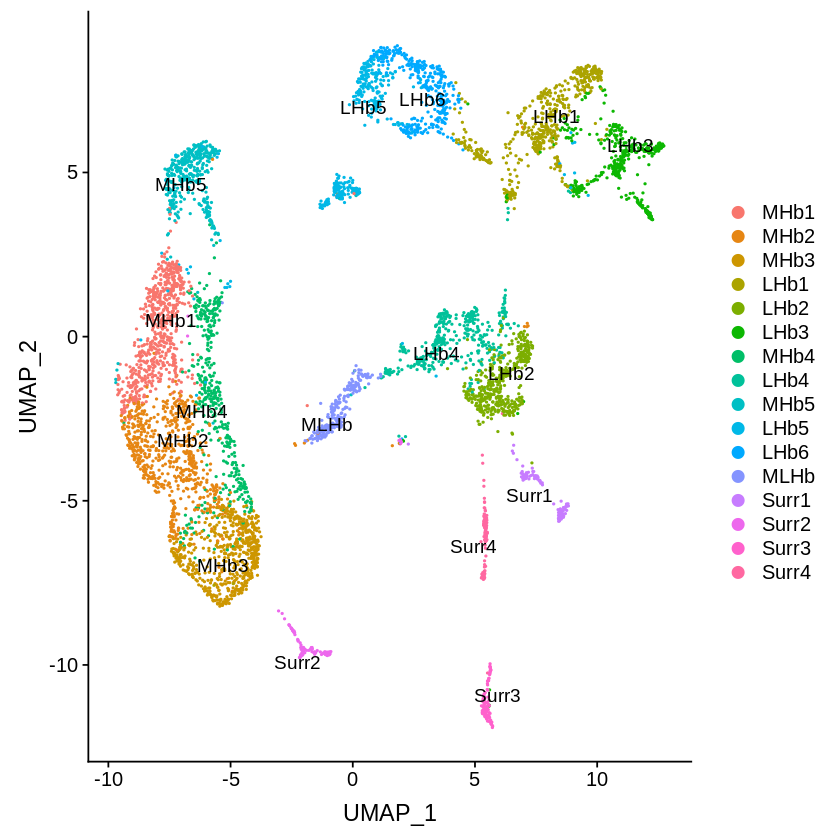

In [32]:
DimPlot(object = LHb.integrated, reduction = "umap", label = TRUE, repel = TRUE) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/umap_name_2000_30_0.8.pdf",width=10,height=12)

# Cell type analysis in each condition

In [8]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(LHb.integrated@assays$RNA@data[,which(Idents(object=LHb.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_cntl",sep=""),intersect(colnames(cntl@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_stim",sep=""),intersect(colnames(stim@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))}

In [9]:
LHb.integrated<-subset(x=LHb.integrated,cells=c(MHb1_barcode,MHb2_barcode,MHb3_barcode,LHb1_barcode,LHb2_barcode,LHb3_barcode,MHb4_barcode,MHb5_barcode,LHb4_barcode,LHb5_barcode,MHb6_barcode,LHb6_barcode))

In [27]:
saveRDS(intersect(colnames(cntl@assays$RNA@counts),colnames(LHb.integrated@assays$RNA@counts)),file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/clean_cntl_barcode.rds")
saveRDS(intersect(colnames(stim@assays$RNA@counts),colnames(LHb.integrated@assays$RNA@counts)),file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/clean_stim_barcode.rds")

In [28]:
celltype<-vector()
for (i in 1:dim(LHb.integrated@meta.data)[1]){
    celltype[i]<-toString(new.ident[LHb.integrated@meta.data$integrated_snn_res.0.8[i]])
}
LHb.integrated@meta.data$celltype<-celltype

In [29]:
saveRDS(LHb.integrated, file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/LHb_integrated_0.8_habenula_only.rds")

In [36]:
pdf(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/cluster_tree_clean.pdf",width=10,height=12,paper='special') 
LHb.integrated <- BuildClusterTree(LHb.integrated, verbose = FALSE, reorder = FALSE)
PlotClusterTree(LHb.integrated)
dev.off()

png 
  2

Warning message:
“Removed 4 rows containing missing values (geom_point).”

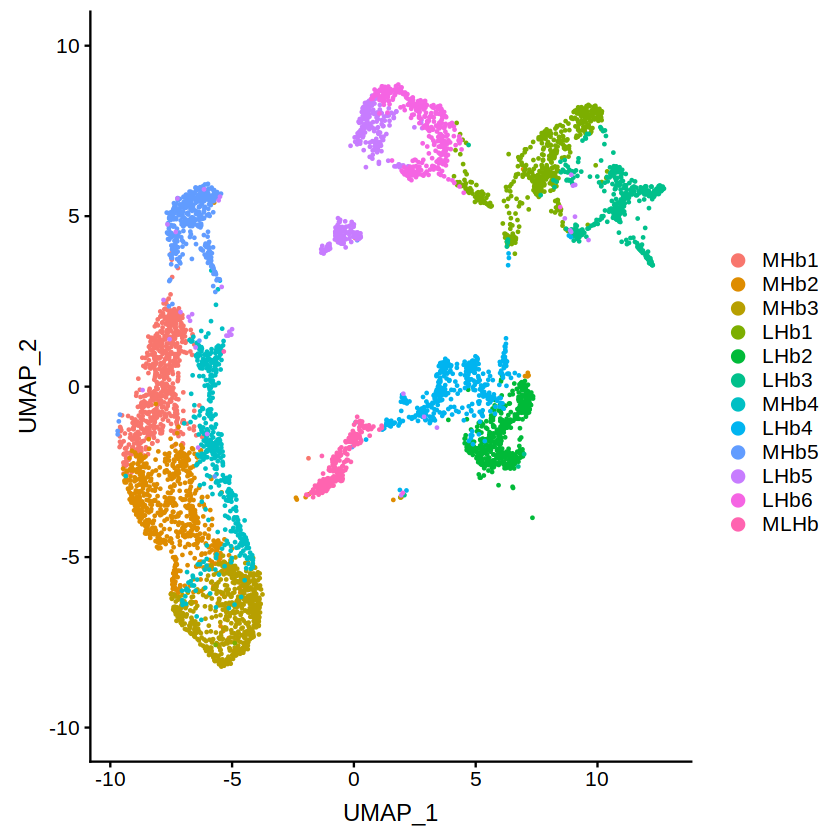

In [14]:
DimPlot(object = LHb.integrated, reduction = "umap", label = FALSE, repel = TRUE)+ylim(-10,10)
#ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/umap_name_2000_30_0.8clean.pdf",width=10,height=12)

Warning message:
“Removed 4 rows containing missing values (geom_point).”

Warning message:
“Removed 4 rows containing missing values (geom_point).”

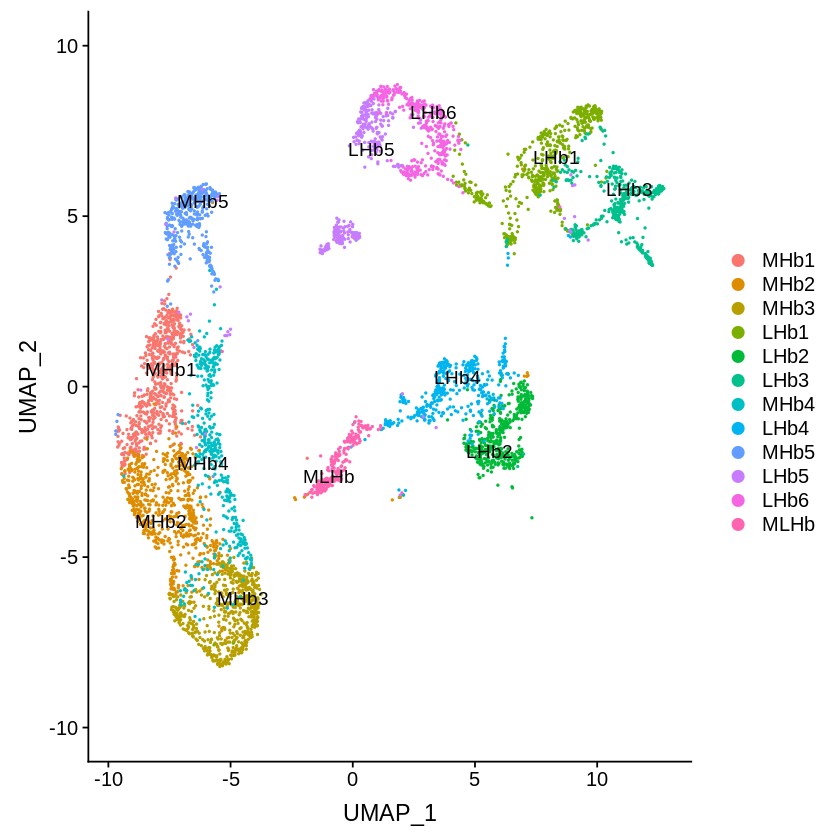

In [38]:
DimPlot(object = LHb.integrated, reduction = "umap", label = TRUE, repel = TRUE)+ylim(-10,10)
ggsave(file="/media/garret/New Volume/scRNAseq_data/Yoshiko/LHb_integrate/clean/Neurons/gene2000_30/umap_name_2000_30_0.8clean.pdf",width=10,height=12)